# Getting the most solar power for your dollar
## Exploratory Data Analysis
### Zachary Brown

Now that the raw data has been wrangled into a useful dataframe it is time to explore the data and identify correlations and trends that may be important for modeling. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(os.getcwd())
os.chdir(r"..\data\interim")
print(os.getcwd())

C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\data\interim


In [3]:
data = pd.read_csv('wrangled_data.csv', index_col=0, low_memory=False)
data.shape

(208257, 57)

In [4]:
data.head()

,data_provider_1,system_id_1,installation_date,system_size_dc,total_installed_price,rebate_or_grant,customer_segment,expansion_system,multiple_phase_system,tracking,...,state_MA,state_MD,state_MN,state_NH,state_NM,state_NY,state_RI,state_TX,state_UT,state_WI
108019,Arizona Public Service,107903,2020-06-17,5.760,17488.26,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108020,Arizona Public Service,107904,2020-06-17,8.750,22631.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108142,Arizona Public Service,108026,2020-06-19,4.725,18972.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108175,Arizona Public Service,108059,2020-06-22,3.550,9900.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108233,Arizona Public Service,108117,2020-06-23,5.850,20475.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.columns

Index(['data_provider_1', 'system_id_1', 'installation_date', 'system_size_dc',
       'total_installed_price', 'rebate_or_grant', 'customer_segment',
       'expansion_system', 'multiple_phase_system', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'utility_service_territory',
       'third_party_owned', 'installer_name', 'self_installed', 'azimuth_1',
       'tilt_1', 'module_manufacturer_1', 'module_model_1',
       'module_quantity_1', 'additional_modules', 'technology_module_1',
       'bipv_module_1', 'bifacial_module_1', 'nameplate_capacity_module_1',
       'efficiency_module_1', 'inverter_manufacturer_1', 'inverter_model_1',
       'inverter_quantity_1', 'additional_inverters', 'micro_inverter_1',
       'solar_storage_hybrid_inverter_1', 'built_in_meter_inverter_1',
       'dc_optimizer', 'inverter_loading_ratio', 'date_of_battery_install',
       'year', 'month', 'price_per_kw', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_DE', 'state_FL', 'state_M

In [12]:
col = data.columns.to_series().groupby(data.dtypes).groups
print(col)

{int64: ['expansion_system', 'multiple_phase_system', 'tracking', 'ground_mounted', 'third_party_owned', 'self_installed', 'module_quantity_1', 'additional_modules', 'bipv_module_1', 'bifacial_module_1', 'additional_inverters', 'micro_inverter_1', 'solar_storage_hybrid_inverter_1', 'built_in_meter_inverter_1', 'dc_optimizer', 'month', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH', 'state_NM', 'state_NY', 'state_RI', 'state_TX', 'state_UT', 'state_WI'], float64: ['system_size_dc', 'total_installed_price', 'rebate_or_grant', 'azimuth_1', 'tilt_1', 'nameplate_capacity_module_1', 'efficiency_module_1', 'inverter_quantity_1', 'inverter_loading_ratio', 'year', 'price_per_kw'], object: ['data_provider_1', 'system_id_1', 'installation_date', 'customer_segment', 'zip_code', 'city', 'utility_service_territory', 'installer_name', 'module_manufacturer_1', 'module_model_1', 'technology_module_1', 'inverter_manufacturer_1', 'in

One useful tool to quickly identify a difference in distributions is the empirical cumulative distribution function (ECDF). I'd like to determine whether there are any clear differences in prices per KW in TX versus the rest of the US, so I will first create a function to quickly produce an EDCF for a given column. Then I'll create two new dataframes, one with just TX data, the other with all other states. Then I'll overlay the ECDFs of both to compare. 

In [6]:
def ecdf(column):
    n = len(column)

    # x-data for the ECDF: x
    x = np.sort(column)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [7]:
# Creating the two new dataframes
tx = data[data['state_TX'] == 1]
not_tx = data[data['state_TX'] == 0]

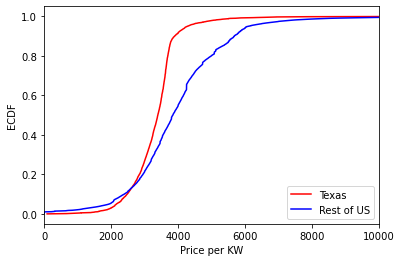

In [10]:
# Plotting the two ECDFs against one another

tx_x, tx_y = ecdf(tx['price_per_kw'])
us_x, us_y = ecdf(not_tx['price_per_kw'])

plt.plot(tx_x, tx_y, color='r')
plt.plot(us_x, us_y, color='b')
plt.xlim(0,10000)
plt.xlabel('Price per KW')
plt.ylabel('ECDF')
plt.legend(['Texas', 'Rest of US'], loc='lower right')
plt.show()

Very interesting! Although the rest of the US has some installations that are more cost efficient than those in Texas, the Texas installations as a whole tend to be more cost efficient than the rest of the country. It seems likely that this will factor into the model later on.

It seems very possible that pricing may vary throughout the year given seasonal changes in weather. For example one might expect an increase in installations, and hence an increase in price, during the winter or spring so that the panels are ready in time for summer. I'll prepare a series of boxplots of the price per KW broken down by month to get a quick look at whether there is any month to month effect.

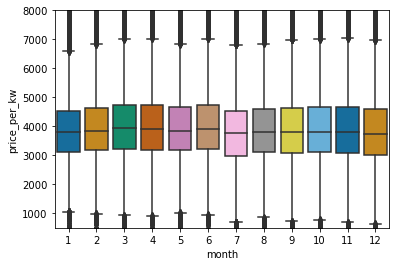

In [9]:
sns.boxplot(x='month', y='price_per_kw', data=data, palette='colorblind')
plt.ylim(500, 8000)
plt.show()

Now I want to check for quick correlations in the categorical columns such as 'expansion_system', 'multiple_phase_system', etc. To do so I'll create a loop to automatically make box plots for each.

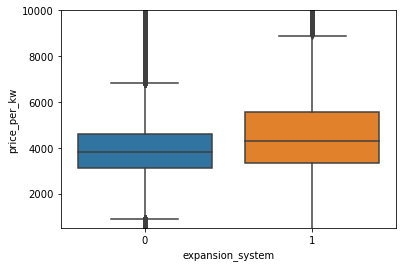

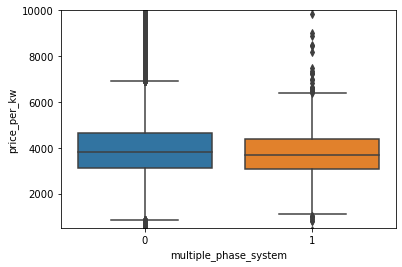

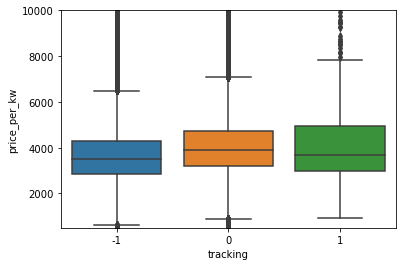

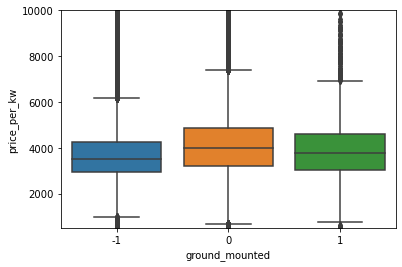

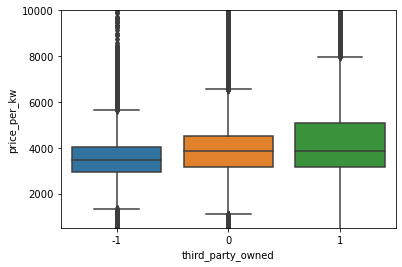

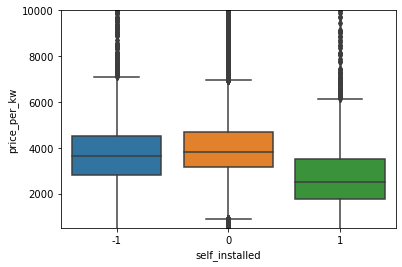

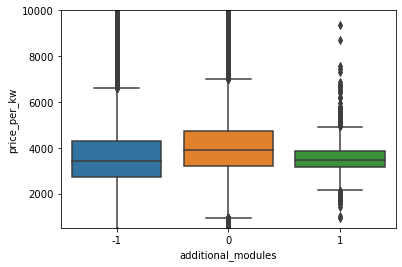

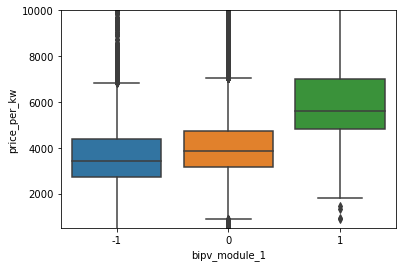

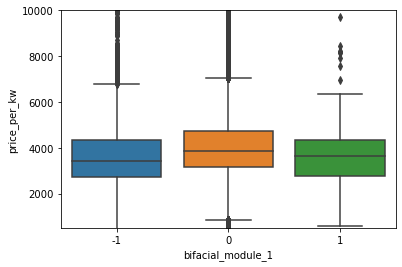

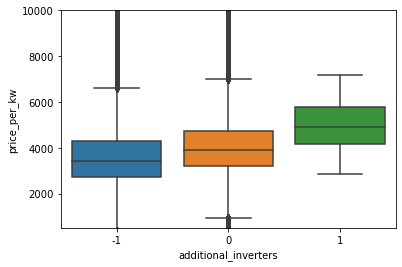

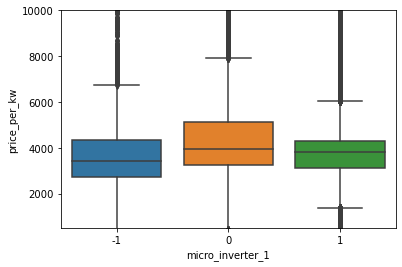

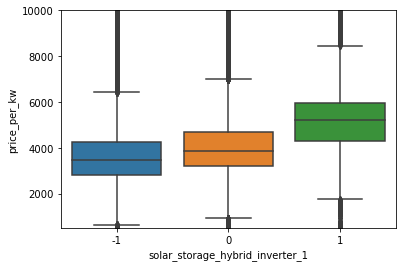

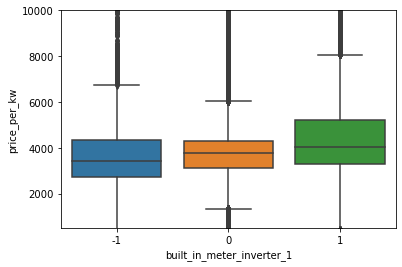

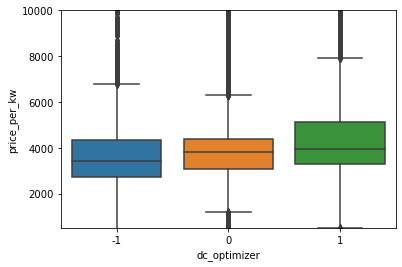

In [20]:
for col in data.columns:
    if data.dtypes[col] == 'int64' and 'state' not in col and 2 not in data[col].unique():
        sns.boxplot(x=col, y='price_per_kw', data=data)
        plt.ylim(500, 10000)
        plt.show()    

While there aren't any plots that show an obvious statistically significant difference between their yes (1) and no (0) values, 'self_installed' and 'additional_modules' appear to improve cost efficiency, while 'bipv_module_1', 'additional_inverters', and 'solar_storage_hybrid_inverter_1' all appear to reduce cost efficiency. These may prove important to model development.